Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Compiling model...
'compile' took 0.000277 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.99e-03, 0.00e+00, 7.67e-01, 0.00e+00, 3.30e-03]    [5.95e-03, 0.00e+00, 7.67e-01, 0.00e+00, 3.30e-03]    []  
100       [9.19e-05, 2.56e-09, 5.81e-08, 1.11e-05, 2.02e-06]    [1.04e-04, 2.56e-09, 5.81e-08, 1.11e-05, 2.02e-06]    []  
200       [5.75e-05, 2.07e-08, 1.62e-08, 3.88e-06, 5.46e-07]    [6.80e-05, 2.07e-08, 1.62e-08, 3.88e-06, 5.46e-07]    []  
300       [4.57e-05, 2.85e-10, 8.34e-09, 1.28e-06, 3.63e-07]    [5.51e-05, 2.85e-10, 8.34e-09, 1.28e-06, 3.63e-07]    []  
400       [3.80e-05, 5.76e-10, 4.84e-09, 7.40e-07, 2.35e-07]    [4.58e-05, 5.76e

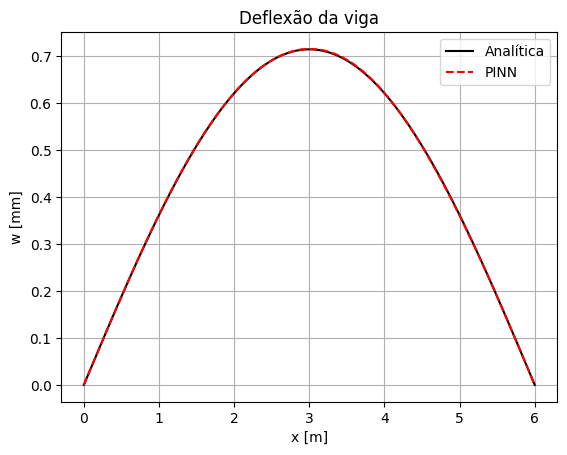

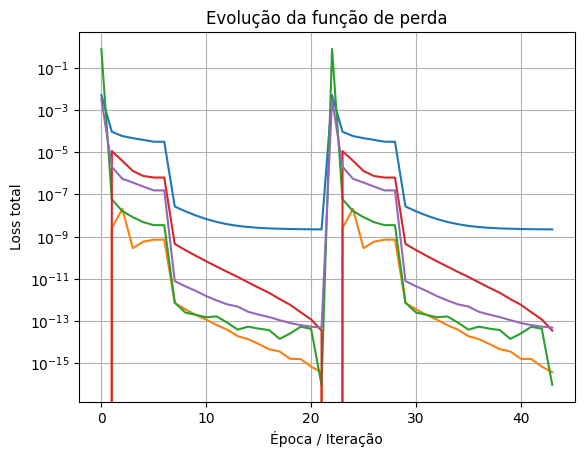

PINN  -> w_max = 0.715 mm , θ_max = 0.000381 rad


In [ ]:
import deepxde as dde, numpy as np, torch, matplotlib.pyplot as plt
dde.backend.set_default_backend("pytorch")

# ------------------- Parâmetros --------------------
L  = 6.0                 # [m]
E  = 2.10e11             # [Pa]
I  = 2.25e-4             # [m^4]
q  = 2.0e3               # [N/m]

# ------------------- PDE ---------------------------
def pde(x, y):
    d2y = dde.grad.hessian(y, x)  # w''
    d4y = dde.grad.hessian(d2y, x) # w''''
    return d4y - q/(E*I)

# ------------------- Geometria ---------------------
geom = dde.geometry.Interval(0.0, L)

def left(x, on_boundary):  return on_boundary and np.isclose(x[0], 0.0)
def right(x, on_boundary): return on_boundary and np.isclose(x[0], L)

bc_w0   = dde.DirichletBC(geom, lambda x: 0.0, left)      # w(0)=0
bc_wL   = dde.DirichletBC(geom, lambda x: 0.0, right)     # w(L)=0
bc_m0 = dde.OperatorBC(
    geom, lambda x, y, dy: dde.grad.hessian(y, x), on_boundary=left)
bc_mL = dde.OperatorBC(
    geom, lambda x, y, dy: dde.grad.hessian(y, x), on_boundary=right)

# ------------------- Dados --------------------------
data = dde.data.PDE(
    geom, pde, [bc_w0, bc_wL, bc_m0, bc_mL],
    num_domain = 1000,
    num_boundary = 200,
    num_test = 200,
)

# ------------------- Rede ---------------------------
layer_size   = [1] + [40] * 3 + [1]
activation   = "sin"
initializer  = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

# ------------------- Treino -------------------------
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, _ = model.train(iterations=500, display_every=100)

model.compile("L-BFGS-B")
losshistory2, train_state = model.train()

# ------------------- Pós-processamento --------------
x = np.linspace(0, L, 200)[:, None]
w_pred  = model.predict(x)

# solução exata para comparação
def w_exact(x):
    return q*x*(L**3 - 2*L*x**2 + x**3)/(24*E*I)
w_ref = w_exact(x)

# ---- Gráfico 1: deslocamento -----------------------
plt.figure()
plt.plot(x, w_ref*1e3, 'k',  label='Analítica')
plt.plot(x, w_pred*1e3,'r--',label='PINN')
plt.xlabel('x [m]'); plt.ylabel('w [mm]')
plt.legend();  plt.grid(True)
plt.title('Deflexão da viga');  plt.show()

# ---- Gráfico 2: perda total ------------------------
loss_total = np.array(losshistory.loss_train + losshistory2.loss_train)
plt.figure()
plt.semilogy(loss_total); plt.xlabel('Época / Iteração')
plt.ylabel('Loss total'); plt.grid(True, which='both')
plt.title('Evolução da função de perda'); plt.show()

# ---- Valores pontuais ------------------------------
x_mid = torch.tensor([[L/2]], dtype=torch.float32, requires_grad=True)
w_mid = model.net(x_mid).item()
x_sup = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
w0    = model.net(x_sup)
dw_dx = torch.autograd.grad(w0, x_sup,
         grad_outputs=torch.ones_like(w0), create_graph=True)[0].item()

print(f"PINN  -> w_max = {w_mid*1e3:.3f} mm , θ_max = {abs(dw_dx):.6f} rad")


In [39]:
w_exact_L = (5*q*L**4)/(384*E*I)
theta_exact = (q*L**3)/(24*E*I)

erro_w = 100 * (abs((w_mid - w_exact_L) / w_exact_L))
erro_theta = 100 * (abs((dw_dx - theta_exact) / theta_exact))

print(f"Erro relativo deflexão: {erro_w:.3f} %")
print(f"Erro relativo ângulo   : {erro_theta:.3f} %")

Erro relativo deflexão: 0.129 %
Erro relativo ângulo   : 0.009 %
